
# **Trabajo de fin de Máster: Categorización de miopías**

### **Anexo 3: Predicción de dioptrías y evaluación de la importancia de las variables biométricas mediante SHAP.**

##### *Por Juan Carlos Velasco Sánchez, Rubén Casal Ferrero y Manuel García González*

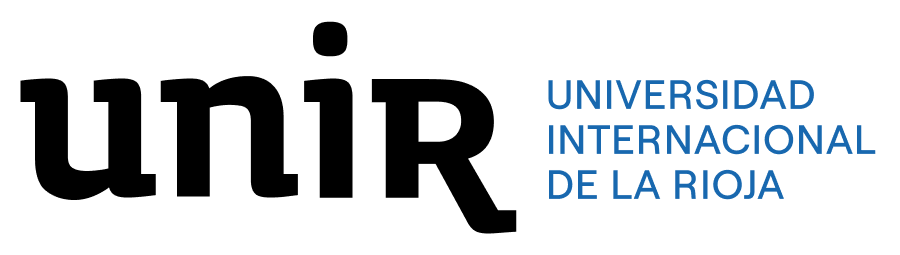

El tercer anexo presenta el desarrollo de un modelo predictivo orientado a la estimación directa del error refractivo (dioptría) a partir de las estructuras biométricas del ojo. A diferencia del enfoque anterior, centrado en reconstruir estructuras a partir de variables indirectas, este modelo toma como entrada las medidas oculares completas disponibles en el dataset —como la longitud axial, el grosor del cristalino, el radio corneal, la profundidad de la cámara anterior o la paquimetría— para predecir el valor final de la dioptría de cada paciente.

Además, una vez entrenado el modelo, se incorpora el uso del método SHAP (SHapley Additive exPlanations) para evaluar la importancia relativa de cada variable en las predicciones del modelo. Esta técnica permite obtener una interpretación tanto global como local de las decisiones del modelo, ayudando a identificar cuáles son las estructuras oculares que más influyen en el desarrollo de la miopía o hipermetropía en cada paciente.



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers

# Calculo Dioptría en el dataset (1000 pacientes)

## Función para aplicar el calculo de la dioptria al dataset

In [ ]:
parametros = {
    'R1': 0.0078,
    'R2': 0.0065,
    'R3': 0.0102,
    'R4': -0.0060,
    'e_cornea': 0.55e-3,
    'camara_ant': 3.6e-3,
    'e_lente': 4e-3,
    'longitud_axial': 0.024,
    # 'longitud_axial': 0.02229, #Cambiado para coincidir
    'n_cornea': 1.3771,
    'n_acuoso': 1.3374,
    'n_cristalino': 1.42,
    'n_vitreo': 1.336
}

###  Función cálculo de dioptrias mediante (AXL)

In [ ]:
def calcular_potencia(axlMM):
    # le GRAND
    axl_lg_MM = 24.2
    n_aire = 1

    # Convertir a metros
    axl_lg_M = axl_lg_MM / 1000
    axlM = axlMM / 1000

    # Potencia total teórica de Le Grand calculada con dos superficies
    potencia_total_teorica = 59.94

    #formula de la potencia = n_ojo - n_aire / axl --> despejar el indice de refracción del ojo
    n_ojo = (potencia_total_teorica * axl_lg_M) + n_aire

    p_paciente = (n_ojo - n_aire) / axlM

    #Diferencia entre la potencia del paciente y la potencia teórica
    dif = p_paciente - potencia_total_teorica
    return dif


In [ ]:
def distancia_imagen(n_final, P_total):
    return n_final / P_total

In [ ]:
def potencia_superficie(n2, n1, R):
    return (n1 - n2) / R

In [ ]:
def potencia_lente_correctora(P_ojo, P_deseada, d):
    # return (P_deseada - P_ojo) / (1 - d * P_deseada)
    return (P_ojo - P_deseada) / (1 - d * P_deseada)

In [ ]:
d1 = 0.02229

###  Función cálculo de dioptrias mediante (AXL, LENS, ACD, PAQ)

In [ ]:
def calc(param, AXL, espesorCristalino, espesorCornea, radioAnteriorCornea, acd):
    radioPosteriorCornea = radioAnteriorCornea * 0.822

    #Potencias superficiales
    Pcornea_anterior = potencia_superficie(1.000, param['n_cornea'], radioAnteriorCornea)
    Pcornea_posterior = potencia_superficie(param['n_cornea'], param['n_acuoso'], radioPosteriorCornea)
    Pcristalino_anterior = potencia_superficie(param['n_acuoso'], param['n_cristalino'], param['R3'])
    Pcristalino_posterior = potencia_superficie (param['n_cristalino'], param['n_vitreo'], param['R4'])

    #Términos de interacción
    Tcornea                 = (espesorCornea / param['n_cornea']) * Pcornea_anterior * Pcornea_posterior
    Tcornea_cristalino      = (acd / param['n_acuoso']) * Pcornea_posterior * Pcristalino_anterior
    Tcristalino             = (espesorCristalino / param['n_cristalino']) * Pcristalino_anterior * Pcristalino_posterior

    #Potencia total
    P_total_4S = Pcornea_anterior + Pcornea_posterior + Pcristalino_anterior + Pcristalino_posterior - Tcornea - Tcornea_cristalino - Tcristalino
    Pcornea = Pcornea_anterior + Pcornea_posterior - (espesorCornea / param['n_cornea']) * Pcornea_anterior * Pcornea_posterior
    Pcristalino = Pcristalino_anterior + Pcristalino_posterior - (espesorCristalino / param['n_cristalino']) * Pcristalino_anterior * Pcristalino_posterior
    P_total_2S = Pcornea + Pcristalino - ((6/ 100000 + 6.02 / 1000) / param['n_acuoso']) * Pcornea * Pcristalino


    s_imagen = distancia_imagen(param['n_vitreo'], P_total_2S)

    distancia_lente_correctora = 0.0012

    #d1 = parametros['longitud_axial'] - (1.91 / 1000)
    d1 = AXL - (1.91 / 1000)
    # Cálculo del error refractivo y potencia de la lente correctora
    error_refractivo = s_imagen - d1

    # Potencia deseada para enfocar en la retina
    P_deseada = param['n_vitreo'] / d1

    # Potencia de la lente correctora (d = distancia desde la lente a la retina)
    d = distancia_lente_correctora  # en metros
    P_lente = potencia_lente_correctora(P_total_2S, P_deseada, d)

    return P_lente

In [ ]:
# cargamos el dataset
data = pd.DataFrame(pd.read_excel("Base Datos Pacientes.xlsx"))
data.head()

,Sexo,F. Nac,F. Ex.,Días,Edad años,OD/OI,AXL,ACD,LENS,Paq,...,K1,Eje K1,K2,Eje K2,Cil,Eje,Km,RaK,SA,V
0,H,1934-12-11,2016-04-26 00:00:00,29295,81.375000,OD,23.30,3.34,4.21,0.570,...,44.09,76,44.84,166,-0.75,76,44.465,7.590240,7.55,15.75
1,H',1934-12-11,2016-04-26 00:00:00,29295,81.375000,OI,23.09,3.27,4.37,0.573,...,44.43,86,45.83,176,-1.40,86,45.130,7.478396,7.64,15.45
2,M,1931-06-16,2016-10-06 00:00:00,30710,85.305556,OD,21.86,2.92,5.21,0.607,...,45.47,143,45.73,53,-0.26,143,45.600,7.401316,8.13,13.73
3,M',1931-06-16,2016-10-06 00:00:00,30710,85.305556,OI,21.72,2.85,5.16,0.588,...,45.60,84,46.58,174,-0.98,84,46.090,7.322630,8.01,13.71
4,M,1947-05-08,2016-11-29 00:00:00,25041,69.558333,OD,21.44,2.43,5.30,0.552,...,44.64,162,44.97,72,-0.33,162,44.805,7.532641,7.73,13.71


In [ ]:
# Añadimos nueva columna, con el valores de las dioptrias de cada paciente
data["Dioptrias"] = data.apply(
    lambda row: calc(parametros, (row['AXL'] / 1000), (row['LENS'] / 1000), (row['Paq'] / 1000), (row['RaK'] / 1000), (row['ACD'] / 1000)),
    axis=1
)
data.head(10)

,Sexo,F. Nac,F. Ex.,Días,Edad años,OD/OI,AXL,ACD,LENS,Paq,...,Eje K1,K2,Eje K2,Cil,Eje,Km,RaK,SA,V,Dioptrias
0,H,1934-12-11,2016-04-26 00:00:00,29295,81.375000,OD,23.30,3.34,4.21,0.570,...,76,44.84,166,-0.75,76,44.465,7.590240,7.55,15.75,-1.670990
1,H',1934-12-11,2016-04-26 00:00:00,29295,81.375000,OI,23.09,3.27,4.37,0.573,...,86,45.83,176,-1.40,86,45.130,7.478396,7.64,15.45,-1.717270
2,M,1931-06-16,2016-10-06 00:00:00,30710,85.305556,OD,21.86,2.92,5.21,0.607,...,143,45.73,53,-0.26,143,45.600,7.401316,8.13,13.73,-5.553518
3,M',1931-06-16,2016-10-06 00:00:00,30710,85.305556,OI,21.72,2.85,5.16,0.588,...,84,46.58,174,-0.98,84,46.090,7.322630,8.01,13.71,-5.601718
4,M,1947-05-08,2016-11-29 00:00:00,25041,69.558333,OD,21.44,2.43,5.30,0.552,...,162,44.97,72,-0.33,162,44.805,7.532641,7.73,13.71,-7.917370
5,M',1947-05-08,2016-11-29 00:00:00,25041,69.558333,OI,21.53,2.49,5.28,0.564,...,170,46.66,80,-1.26,170,46.030,7.332175,7.77,13.76,-6.389554
6,M,1927-08-08,2016-03-15 00:00:00,31897,88.602778,OD,23.05,2.62,4.95,0.522,...,166,44.13,76,-0.98,166,43.640,7.733731,7.57,15.48,-3.322076
7,M',1927-08-08,2016-03-15 00:00:00,31897,88.602778,OI,23.15,2.49,5.37,0.510,...,0,44.18,90,-1.78,0,43.290,7.796258,7.86,15.29,-3.365032
8,H,1949-08-03,2016-09-12 00:00:00,24159,67.108333,OD,23.59,3.40,4.20,0.521,...,12,45.97,102,-1.57,12,45.185,7.469293,7.60,15.99,-0.090923
9,H',1949-08-03,2016-09-12 00:00:00,24159,67.108333,OI,23.59,3.50,3.93,0.527,...,174,46.37,84,-1.95,174,45.395,7.434740,7.43,16.16,0.129246


# Preparación de los datos para el entrenamiento


## 1. Objetivo
Preparar las variables de entrada y salida para entrenar una red neuronal que prediga parámetros biométricos oculares.

---

## 2. Definición de variables

- Entrada (`X`):
  - `ACD`, `CW`, `K1`, `K2`, `Edad años`, `Sexo`, `SA`, `V`, `Dioptrias`
  - Se elimina `Km` por ser derivable de `K1` y `K2`, lo que podría introducir colinealidad no deseada.

- Salida (`y`):
  - `AXL`, `LENS`, `Paq`, `RaK` (valores biométricos clave en la estimación de la refracción)

---

## 3. Codificación de variables categóricas

- La variable `Sexo` se transforma a valores numéricos:
  - Hombre (`H`, `H'`) → 0  
  - Mujer (`M`, `M'`) → 1

---

## 4. División del dataset

```python
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
t_size=0.2, random_state=42
)


In [ ]:
data.columns

Index(['Sexo', 'F. Nac', 'F. Ex.', 'Días', 'Edad años', 'OD/OI', 'AXL', 'ACD',
       'LENS', 'Paq', 'CW', 'K1', 'Eje K1', 'K2', 'Eje K2', 'Cil', 'Eje', 'Km',
       'RaK', 'SA', 'V', 'Dioptrias'],
      dtype='object')

In [ ]:
print(data.shape)
print(data.describe())

(1483, 22)
                              F. Nac          Días    Edad años          AXL  \
count                           1483   1483.000000  1483.000000  1483.000000   
mean   1940-11-06 12:10:11.732973696  27203.175320    75.564376    23.517736   
min              1916-03-28 00:00:00   8997.000000    24.991667    20.630000   
25%              1933-09-15 00:00:00  25147.500000    69.854167    22.670000   
50%              1939-05-20 00:00:00  27689.000000    76.913889    23.230000   
75%              1946-06-05 00:00:00  29749.500000    82.637500    23.990000   
max              1991-03-17 00:00:00  36000.000000   100.000000    33.740000   
std                              NaN   3460.435558     9.612321     1.488427   

               ACD         LENS          Paq           CW           K1  \
count  1483.000000  1483.000000  1483.000000  1483.000000  1483.000000   
mean      3.156906     4.620762     0.543053    11.485496    43.913722   
min       1.610000     3.260000     0.415000  

Comprobar si hay nulos

In [ ]:
print(data.isnull().sum())

Sexo         0
F. Nac       0
F. Ex.       0
Días         0
Edad años    0
OD/OI        0
AXL          0
ACD          0
LENS         0
Paq          0
CW           0
K1           0
Eje K1       0
K2           0
Eje K2       0
Cil          0
Eje          0
Km           0
RaK          0
SA           0
V            0
Dioptrias    0
dtype: int64


In [ ]:
data.dtypes

Sexo                 object
F. Nac       datetime64[ns]
F. Ex.               object
Días                  int64
Edad años           float64
OD/OI                object
AXL                 float64
ACD                 float64
LENS                float64
Paq                 float64
CW                  float64
K1                  float64
Eje K1                int64
K2                  float64
Eje K2               object
Cil                 float64
Eje                   int64
Km                  float64
RaK                 float64
SA                  float64
V                   float64
Dioptrias           float64
dtype: object

Corrección de tipos de datos

In [ ]:
#Convertir la columna Eje K2 a tipo numérico
data['Eje K2'] = pd.to_numeric(data['Eje K2'], errors='coerce')

#Eliminar filas con valores NaN
data.dropna(inplace=True)

Eliminar variables redundantes o innecesarias

In [ ]:
#Eliminar fecha de nacimiento y días ya que representa lo mismo que 'Edad años'
data.drop(columns=["F. Nac"], inplace=True)
data.drop(columns=["Días"], inplace=True)

#Eliminar la variable "F. Ex." ya que es irrelevante para el proyecto
data.drop(columns=["F. Ex."], inplace=True)

Codificación de variables

In [ ]:
#Codificar la columna sexo a valor numérico
data['Sexo'] = data['Sexo'].replace({'H': 0, 'H\'': 0, 'M': 1, 'M\'': 1})

#Codificar la columna OD/OI a valor numérico
data['OD/OI'] = data['OD/OI'].replace({'OD': 0, 'OI': 1})

Manejo de outliers

In [ ]:
def clean_dataset(data):
    #No tiene mucho sentido buscar outliers en la edad
    not_available_columns = ['Edad años']

    cleaned_data = data.copy()
    for col in data.columns:
        if col in cleaned_data.columns:
            if cleaned_data[col].dtype in ['float64', 'int64'] and col not in not_available_columns:
                # Calcular cuartiles
                q1 = cleaned_data[col].quantile(0.25)
                q3 = cleaned_data[col].quantile(0.75)
                iqr = q3 - q1

                # Calcular límites
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr

                # Contar outliers antes de eliminar
                outliers_count = len(cleaned_data[(cleaned_data[col] < lower_bound) |
                                                (cleaned_data[col] > upper_bound)])

                # Filtrar outliers
                cleaned_data = cleaned_data[(cleaned_data[col] >= lower_bound) &
                                          (cleaned_data[col] <= upper_bound)]

                print(f"Columna '{col}': Eliminados {outliers_count} outliers "
                      f"(límites: {lower_bound:.2f} - {upper_bound:.2f})")

    print(f"\nDataset original: {len(data)} filas")
    print(f"Dataset limpio: {len(cleaned_data)} filas")
    print(f"Filas eliminadas: {len(data) - len(cleaned_data)} ({(len(data) - len(cleaned_data))/len(data)*100:.1f}%)")
    return cleaned_data


In [ ]:
#Eliminar outliers
data = clean_dataset(data)

#Se pierden muchas filas al eliminar outliers. Sería interesante buscar otros métodos para manejarlos en lugar de eliminarlos

Columna 'Sexo': Eliminados 0 outliers (límites: -1.50 - 2.50)
Columna 'OD/OI': Eliminados 0 outliers (límites: -1.50 - 2.50)
Columna 'AXL': Eliminados 91 outliers (límites: 20.69 - 25.97)
Columna 'ACD': Eliminados 5 outliers (límites: 2.03 - 4.22)
Columna 'LENS': Eliminados 14 outliers (límites: 3.48 - 5.77)
Columna 'Paq': Eliminados 6 outliers (límites: 0.45 - 0.63)
Columna 'CW': Eliminados 8 outliers (límites: 10.36 - 12.57)
Columna 'K1': Eliminados 12 outliers (límites: 39.86 - 48.05)
Columna 'Eje K1': Eliminados 1 outliers (límites: -122.62 - 268.38)
Columna 'K2': Eliminados 7 outliers (límites: 40.88 - 49.01)
Columna 'Eje K2': Eliminados 0 outliers (límites: -89.00 - 247.00)
Columna 'Cil': Eliminados 71 outliers (límites: -2.55 - 0.73)
Columna 'Eje': Eliminados 0 outliers (límites: -119.00 - 265.00)
Columna 'Km': Eliminados 0 outliers (límites: 40.56 - 48.30)
Columna 'RaK': Eliminados 3 outliers (límites: 6.94 - 8.26)
Columna 'SA': Eliminados 14 outliers (límites: 6.85 - 8.65)
Col

Correlación de variables

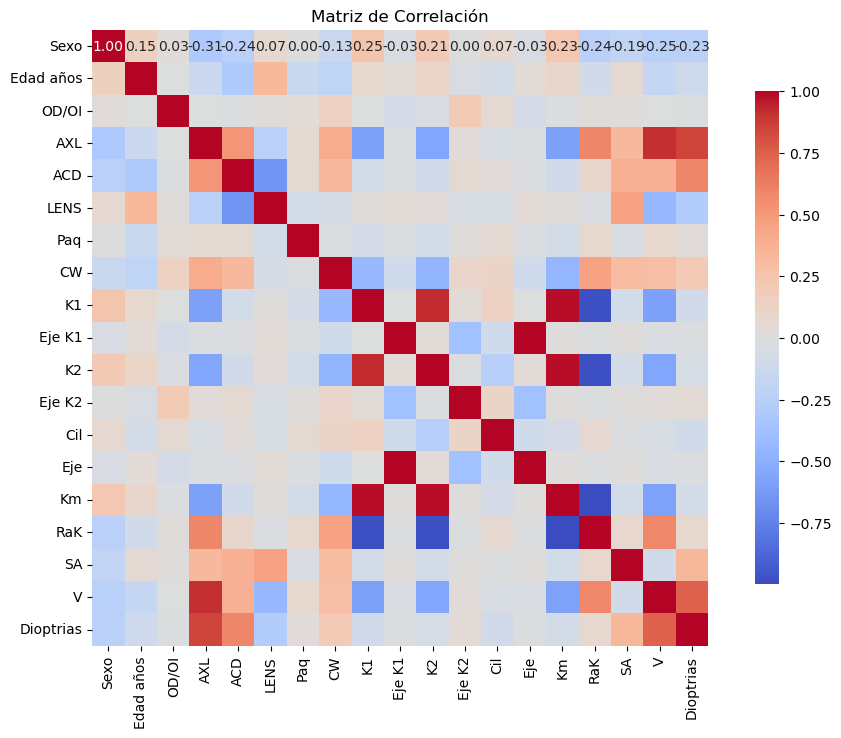

In [ ]:
#Matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación')
plt.show()

Eliminar variables correlacionadas

In [ ]:
#Eliminar K1 y K2 -> correlación de casi 1 con Km
data.drop(columns=["K1", "K2"], inplace=True)

#Eliminar Eje ó Eje K1 -> correlación de 1
data.drop(columns=["Eje"], inplace=True)

#Eliminar Km -> correlación de 1 con RaK
data.drop(columns=["Km"], inplace=True)

Matriz de correlación con las variables limpiadas

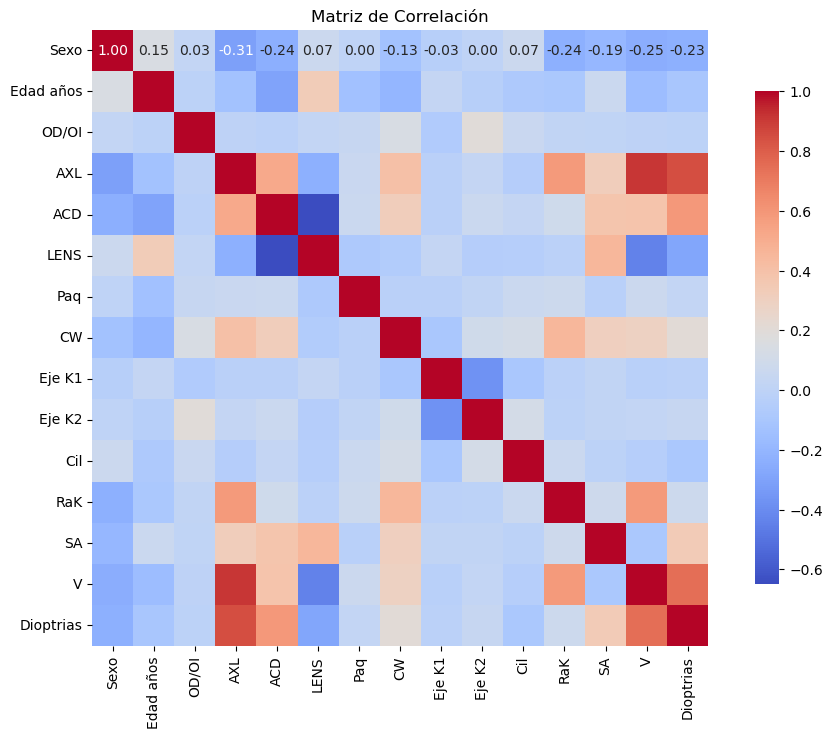

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación')
plt.show()

In [ ]:
# Parámetros de entrada del modelo
parametros_entrada = ['CW', 'Edad años', 'Sexo', 'SA', 'V',"AXL", "LENS", "Paq", "RaK", "ACD" ]


#He visto que usar V, Edad años y sexo no influyen demasiado en el resultado del entrenamiento
#(se pierde algo de R2 en el Paq pero se gana en el resto)

#Sería interesante ver si hay alguna variable que pueda mejorar la explicabilidad del Paq

In [ ]:
# Definir parametros de salida de la red
parametros_target = ['Dioptrias']

In [ ]:
data.head()

,Sexo,Edad años,OD/OI,AXL,ACD,LENS,Paq,CW,Eje K1,Eje K2,Cil,RaK,SA,V,Dioptrias
0,0,81.375000,0,23.30,3.34,4.21,0.570,11.01,76,166.0,-0.75,7.590240,7.55,15.75,-1.670990
1,0,81.375000,1,23.09,3.27,4.37,0.573,10.91,86,176.0,-1.40,7.478396,7.64,15.45,-1.717270
2,1,85.305556,0,21.86,2.92,5.21,0.607,11.10,143,53.0,-0.26,7.401316,8.13,13.73,-5.553518
3,1,85.305556,1,21.72,2.85,5.16,0.588,11.17,84,174.0,-0.98,7.322630,8.01,13.71,-5.601718
5,1,69.558333,1,21.53,2.49,5.28,0.564,11.11,170,80.0,-1.26,7.332175,7.77,13.76,-6.389554


In [ ]:
validacion_informe = data[-10:]
data = data[:-10]

print(data.shape)
print(validacion_informe.shape)

(1188, 15)
(10, 15)


In [ ]:
validacion_informe.head(10)

,Sexo,Edad años,OD/OI,AXL,ACD,LENS,Paq,CW,Eje K1,Eje K2,Cil,RaK,SA,V,Dioptrias
1468,0,79.569444,1,23.87,3.42,4.66,0.531,11.79,78,168.0,-0.88,7.621951,8.08,15.79,-0.134613
1469,1,89.913889,0,22.97,2.86,4.71,0.493,11.56,90,0.0,-0.78,7.767549,7.57,15.40,-3.753990
1470,1,89.913889,1,22.85,2.70,5.03,0.485,11.58,95,5.0,-1.57,7.886435,7.73,15.12,-4.799459
1473,1,44.322222,0,22.72,3.32,4.21,0.552,11.98,12,102.0,-0.96,7.691431,7.53,15.19,-4.124564
1474,1,44.322222,1,23.01,3.22,4.31,0.553,12.03,166,76.0,-0.96,7.712523,7.53,15.48,-3.286319
1475,0,84.088889,0,24.36,3.34,5.23,0.549,11.61,101,11.0,-2.29,7.729303,8.57,15.79,0.675228
1476,0,84.088889,1,24.69,3.70,4.84,0.516,11.83,90,0.0,-1.85,7.802566,8.54,16.15,1.232408
1477,1,83.075000,0,23.62,3.07,4.58,0.498,11.44,27,117.0,-1.19,8.027114,7.65,15.97,-3.022539
1480,0,84.541667,0,23.57,3.40,4.81,0.476,11.55,136,46.0,-0.64,7.658271,8.21,15.36,-1.267450
1481,0,84.541667,1,23.76,3.95,4.11,0.477,11.77,75,165.0,-1.92,7.526762,8.06,15.70,0.094107


In [ ]:
X = data[parametros_entrada].values
y = data[parametros_target].values

## Dividimos los datos de entrenamiento

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
X_test_copia = X_test.copy()

In [ ]:
print(X_train.shape)
print(y_train.shape)

(950, 10)
(950, 1)


# PINNS Class



###  Inicialización del Modelo

```python
PINN_model(X_train, X_test, y_train, y_test, lambda_data=1.0, lambda_physics=0.5)
```

* **Parámetros:**

  * `X_train`, `X_test`: Conjunto de datos de entrada para entrenamiento y validación.
  * `y_train`, `y_test`: Conjunto de datos objetivo para entrenamiento y validación.
  * `lambda_data`: Peso asignado a la pérdida relacionada con los datos.
  * `lambda_physics`: Peso asignado a la pérdida relacionada con las restricciones físicas.

* **Acciones internas:**

  * Normaliza internamente las entradas y salidas mediante Z-score (media y desviación estándar del conjunto de entrenamiento).
  * Inicializa el optimizador Adam con una tasa de aprendizaje de 0.001.
  * Inicializa un diccionario `self.history` para registrar las pérdidas durante el entrenamiento.

---

###  Arquitectura de la Red Neuronal

* **Capas:** `[input_dim, 64, 128, 64, 32, output_dim]`
* **Funciones de Activación:**

  * Capas ocultas: `tanh`
  * Capa de salida: `linear`

---

###  Métodos Principales

####  `call(features)`

* Realiza un forward pass a través de la red.

####  `calculo_error_refractivo_tensores(axl, lens, paq, rak, acd)`

* Calcula el error refractivo basado en el modelo óptico de LeGrand usando parámetros oculares específicos.

####  `total_loss(l_data, l_physics)`

* Combina las pérdidas de datos y física usando los pesos `lambda_data` y `lambda_physics`.

####  `train_step(x_scaled, y_scaled, x_orig)`

* Ejecuta un paso de entrenamiento:

  * Calcula las pérdidas de datos (`l_data`) y física (`l_physics`).
  * Calcula gradientes usando `tf.GradientTape` y actualiza los pesos.

####  `val_step(x_scaled, y_scaled, x_orig)`

* Ejecuta un paso de validación:

  * Similar a `train_step` pero sin actualización de pesos.

####  `fit_PINN(num_epochs, print_every=100, save_path='best_model.weights.h5')`

* Entrena la red durante el número especificado de épocas (`num_epochs`).
* Guarda el mejor modelo encontrado basado en la pérdida de validación.
* Registra pérdidas en `self.history`.
* Muestra estadísticas de entrenamiento cada `print_every` épocas.

####  `plot_history()`

* Grafica la evolución de las pérdidas registradas durante el entrenamiento:

  * Total Loss, Data Loss y Physics Loss, tanto para entrenamiento como validación.

####  `predict_fn(X_input)`

* Realiza predicciones en nuevas entradas, aplicando automáticamente la normalización y desnormalización.

---

###  Diccionario `self.history`

Almacena la evolución de las pérdidas durante el entrenamiento:

* `train_total`, `val_total`: pérdidas totales.
* `train_data`, `val_data`: pérdidas asociadas a los datos.
* `train_physics`, `val_physics`: pérdidas asociadas a las restricciones físicas.

---
edict_fn(X_new)
```

---

### 🔗 Dependencias

* TensorFlow
* Matplotlib (para gráficos)

---

### 📝


In [ ]:


class PINN_model(tf.keras.Model):
    def __init__(self, X_train, X_test, y_train, y_test, lambda_data=1.0, lambda_physics=0.5, **kwargs):
        super(PINN_model, self).__init__(**kwargs)
        # Valores de ponderación del error PINNs
        self.lambda_data = lambda_data
        self.lambda_physics = lambda_physics

        self.X_test_no_norm =tf.constant(X_test, dtype=tf.float32)

        # Datos con los que se va a realizar el entrenamiento
        self.X_train = tf.constant(X_train, dtype=tf.float32)
        self.X_test = tf.constant(X_test, dtype=tf.float32)
        self.y_train = tf.constant(y_train, dtype=tf.float32)
        self.y_test = tf.constant(y_test, dtype=tf.float32)

        # Normalización de los datos
        self.X_mean = tf.reduce_mean(self.X_train, axis=0)
        self.X_std = tf.math.reduce_std(self.X_train, axis=0)
        self.y_mean = tf.reduce_mean(self.y_train, axis=0)
        self.y_std = tf.math.reduce_std(self.y_train, axis=0)

        self.X_train_norm = (self.X_train - self.X_mean) / self.X_std
        self.X_test_norm = (self.X_test - self.X_mean) / self.X_std
        self.y_train_norm = (self.y_train - self.y_mean) / self.y_std
        self.y_test_norm = (self.y_test - self.y_mean) / self.y_std

        # Hiperparametros del entrenamiento
        self.learning_rate = 0.001
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.activation = 'tanh'

        # Arquitectura de la red neuronal
        self.dense0 = layers.Dense(X_train.shape[1], activation=self.activation)
        self.dense1 = layers.Dense(64, activation=self.activation)
        self.dense2 = layers.Dense(128, activation=self.activation)
        self.dense3 = layers.Dense(64, activation=self.activation)
        self.dense4 = layers.Dense(32, activation=self.activation)
        self.output_layer = layers.Dense(y_train.shape[1])

        # Datos último entrenamiento
        self.history = {
            'train_total': [],
            'val_total': [],
            'train_data': [],
            'val_data': [],
            'train_physics': [],
            'val_physics': []
        }

    def call(self, features):
        x = self.dense0(features)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return self.output_layer(x)


    def calculo_error_refractivo_tensores(self, axl_tensor, lens_tensor, paq_tensor, rak_tensor, acd_tensor):


        """Calculo del error refractivo para modelo tensorflow"""
        radioPosteriorCornea = rak_tensor * 0.822

        #Potencias superficiales
        Pcornea_anterior = potencia_superficie(1.000, parametros['n_cornea'], rak_tensor)
        Pcornea_posterior = potencia_superficie(parametros['n_cornea'], parametros['n_acuoso'], radioPosteriorCornea)
        Pcristalino_anterior = potencia_superficie(parametros['n_acuoso'], parametros['n_cristalino'], parametros['R3'])
        Pcristalino_posterior = potencia_superficie (parametros['n_cristalino'], parametros['n_vitreo'], parametros['R4'])

        #Términos de interacción
        Tcornea                 = (paq_tensor / parametros['n_cornea']) * Pcornea_anterior * Pcornea_posterior
        Tcornea_cristalino      = (acd_tensor / parametros['n_acuoso']) * Pcornea_posterior * Pcristalino_anterior
        Tcristalino             = (lens_tensor / parametros['n_cristalino']) * Pcristalino_anterior * Pcristalino_posterior

        #Potencia total
        P_total_4S = Pcornea_anterior + Pcornea_posterior + Pcristalino_anterior + Pcristalino_posterior - Tcornea - Tcornea_cristalino - Tcristalino
        Pcornea = Pcornea_anterior + Pcornea_posterior - (paq_tensor / parametros['n_cornea']) * Pcornea_anterior * Pcornea_posterior
        Pcristalino = Pcristalino_anterior + Pcristalino_posterior - (lens_tensor / parametros['n_cristalino']) * Pcristalino_anterior * Pcristalino_posterior
        P_total_2S = Pcornea + Pcristalino - ((6/ 100000 + 6.02 / 1000) / parametros['n_acuoso']) * Pcornea * Pcristalino


        s_imagen = distancia_imagen(parametros['n_vitreo'], P_total_2S)

        distancia_lente_correctora = 0.0012

        d2 = axl_tensor - (1.91 / 1000)


        # Cálculo del error refractivo y potencia de la lente correctora
        error_refractivo = s_imagen - d2

        # Potencia deseada para enfocar en la retina
        P_deseada = parametros['n_vitreo'] / d2

        # Potencia de la lente correctora (d = distancia desde la lente a la retina)
        d = distancia_lente_correctora  # en metros
        P_lente = potencia_lente_correctora(P_total_2S, P_deseada, d)
        return P_lente

    def total_loss(self, l_data, l_physics):
        """Función de pérdidad total PINNs"""
        return self.lambda_data * l_data + self.lambda_physics * l_physics

    @tf.function
    def train_step(self, x_scaled, y_scaled, x_orig):
        """Función step del entrenamiento"""
        with tf.GradientTape() as tape:
            y_pred_scaled = self(x_scaled, training=True)
            l_data = tf.reduce_mean(tf.square(y_pred_scaled - y_scaled))

            y_pred_orig = y_pred_scaled * self.y_std + self.y_mean
            dioptrias_pred = tf.squeeze(y_pred_orig)

            axl = tf.squeeze(x_orig[:, 5])   # columnas 5 a 9
            lens = tf.squeeze(x_orig[:, 6])
            paq = tf.squeeze(x_orig[:, 7])
            rak = tf.squeeze(x_orig[:, 8])
            acd = tf.squeeze(x_orig[:, 9])


            error_refractivo = self.calculo_error_refractivo_tensores(axl / 1000, lens / 1000, paq / 1000, rak / 1000, acd / 1000)
            l_physics = tf.reduce_mean(tf.square(error_refractivo - dioptrias_pred))
            """
            print(f"dioptria físico: {error_refractivo}")
            print(f"dioptria real: {error_refractivo}")
            print(f"dioptria predecida: {y_scaled}")
            """
            total_loss = self.total_loss(l_data, l_physics)

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return total_loss, l_data, l_physics

    @tf.function
    def val_step(self, x_scaled, y_scaled, x_orig):
        """Paso de validación del entrenamiento"""
        y_pred_scaled = self(x_scaled, training=False)
        l_data_val = tf.reduce_mean(tf.square(y_pred_scaled - y_scaled))

        y_pred_orig = y_pred_scaled * self.y_std + self.y_mean
        dioptrias_pred = tf.squeeze(y_pred_orig)

        axl = tf.squeeze(x_orig[:, 5])   # columnas 5 a 9
        lens = tf.squeeze(x_orig[:, 6])
        paq = tf.squeeze(x_orig[:, 7])
        rak = tf.squeeze(x_orig[:, 8])
        acd = tf.squeeze(x_orig[:, 9])

        error_refractivo = self.calculo_error_refractivo_tensores(axl / 1000, lens / 1000, paq / 1000, rak / 1000, acd / 1000)
        l_physics_val = tf.reduce_mean(tf.square(error_refractivo - dioptrias_pred))
        loss_val = self.total_loss(l_data_val, l_physics_val)
        return loss_val, l_data_val, l_physics_val

    def fit_PINN(self, num_epochs, print_every=100, save_path='best_model.weights.h5'):
        """Entrenamiento del modelo"""
        best_val_loss = float('inf')
        best_epoch = 0

        history = {
            'train_total': [],
            'val_total': [],
            'train_data': [],
            'val_data': [],
            'train_physics': [],
            'val_physics': []
        }

        for epoch in range(num_epochs):
            loss_train, l_data_train, l_physics_train = self.train_step(
                self.X_train_norm, self.y_train_norm, self.X_train
            )
            loss_val, l_data_val, l_physics_val = self.val_step(
                self.X_test_norm, self.y_test_norm, self.X_test
            )

            # Guardar historial
            history['train_total'].append(loss_train.numpy())
            history['val_total'].append(loss_val.numpy())
            history['train_data'].append(l_data_train.numpy())
            history['val_data'].append(l_data_val.numpy())
            history['train_physics'].append(l_physics_train.numpy())
            history['val_physics'].append(l_physics_val.numpy())

            if loss_val.numpy() < best_val_loss:
                best_val_loss = loss_val.numpy()
                best_epoch = epoch + 1
                self.save_weights(save_path)

            if (epoch + 1) % print_every == 0:
                print(f"Epoch {epoch+1}/{num_epochs} - Train: {loss_train:.4f} (Data: {l_data_train:.4f}, Physics: {l_physics_train:.4f}) | Val: {loss_val:.4f} (Data: {l_data_val:.4f}, Physics: {l_physics_val:.4f})")

        print(f"Entrenamiento finalizado. Mejor modelo en época {best_epoch} con pérdida de validación: {best_val_loss:.4f}")
        self.load_weights(save_path)
        self.history = history

        return history

    def predict_fn_no_norm(self,X_input):
        X_input_tf = tf.constant(X_input, dtype=tf.float32)
        y_pred_norm = model(X_input_tf, training=False)
        y_pred = y_pred_norm * model.y_std + model.y_mean
        return y_pred.numpy()

    def predict_fn(self, X_input):
        X_input = tf.constant(X_input, dtype=tf.float32)
        X_input_norm = (X_input - self.X_mean) / self.X_std
        y_pred_norm = self(X_input_norm, training=False)
        y_pred = y_pred_norm * self.y_std + self.y_mean
        return y_pred.numpy()

    def plot_history(self):
        """ Función para graficar los resultados del último entrenamiento realizado"""
        if self.history is None or len(self.history['train_total']) == 0:
            print("No hay historial de entrenamiento disponible.")
            return

        epochs = range(1, len(self.history['train_total']) + 1)

        plt.figure(figsize=(18, 5))

        # Pérdida total
        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.history['train_total'], label='Train Total Loss')
        plt.plot(epochs, self.history['val_total'], label='Val Total Loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Total Loss")
        plt.legend()

        # Pérdida de datos
        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.history['train_data'], label='Train Data Loss')
        plt.plot(epochs, self.history['val_data'], label='Val Data Loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Data Loss")
        plt.legend()

        # Pérdida física
        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.history['train_physics'], label='Train Physics Loss')
        plt.plot(epochs, self.history['val_physics'], label='Val Physics Loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Physics Loss")
        plt.legend()

        plt.tight_layout()
        plt.show()


# Entrenamiento de Physical Informed Neural Networks

## Inicialización de la clase PINN_model

In [ ]:
model = PINN_model(
    X_train, X_test,
    y_train, y_test,
    lambda_data=0.5,
    lambda_physics=0.5
)


## Entrenamiento


In [ ]:
history = model.fit_PINN(
    num_epochs=1000,
    print_every=100,  # Muestra progreso cada 100 epochs
    save_path='best_model_PINN.weights.h5'
)

Epoch 100/1000 - Train: 0.1236 (Data: 0.0489, Physics: 0.1983) | Val: 0.1565 (Data: 0.0619, Physics: 0.2512)
Epoch 200/1000 - Train: 0.0546 (Data: 0.0216, Physics: 0.0877) | Val: 0.0854 (Data: 0.0338, Physics: 0.1370)
Epoch 300/1000 - Train: 0.0254 (Data: 0.0101, Physics: 0.0408) | Val: 0.0467 (Data: 0.0185, Physics: 0.0749)
Epoch 400/1000 - Train: 0.0126 (Data: 0.0050, Physics: 0.0202) | Val: 0.0288 (Data: 0.0114, Physics: 0.0461)
Epoch 500/1000 - Train: 0.0072 (Data: 0.0029, Physics: 0.0116) | Val: 0.0198 (Data: 0.0078, Physics: 0.0317)
Epoch 600/1000 - Train: 0.0047 (Data: 0.0019, Physics: 0.0076) | Val: 0.0150 (Data: 0.0059, Physics: 0.0240)
Epoch 700/1000 - Train: 0.0034 (Data: 0.0013, Physics: 0.0055) | Val: 0.0122 (Data: 0.0048, Physics: 0.0196)
Epoch 800/1000 - Train: 0.0026 (Data: 0.0010, Physics: 0.0042) | Val: 0.0104 (Data: 0.0041, Physics: 0.0167)
Epoch 900/1000 - Train: 0.0021 (Data: 0.0008, Physics: 0.0034) | Val: 0.0091 (Data: 0.0036, Physics: 0.0146)
Epoch 1000/1000 - T

In [ ]:
# Seleccionar índice de ejemplo
sample_idx = 3  # Puedes cambiar el índice entre 0 y len(X_test)-1

# Extraer fila de test y valor real
x_sample = X_test[sample_idx:sample_idx+1]
y_real = y_test[sample_idx]

# Convertir a DataFrame para visualización clara
feature_names = ['Edad', 'Sexo', 'Altura', 'Peso', 'Presion', 'AXL', 'LENS', 'PAQ', 'RaK', 'ACD']
x_df = pd.DataFrame(x_sample, columns=feature_names)

print("=== Datos biométricos del paciente ===")
display(x_df)
print(f"Dioptría real: {y_real[0]:.3f}")

# Predicción con PINN
y_pred = model.predict_fn(x_sample)
print(f"Dioptría estimada por PINN: {y_pred[0][0]:.3f}")


=== Datos biométricos del paciente ===


,Edad,Sexo,Altura,Peso,Presion,AXL,LENS,PAQ,RaK,ACD
0,10.97,74.705556,1.0,7.09,15.9,22.99,4.09,0.565,7.607348,3.0


Dioptría real: -2.755
Dioptría estimada por PINN: -2.763


In [ ]:
# Lista de parámetros de entrada
parametros_entrada = ['CW', 'Edad años', 'Sexo', 'SA', 'V', 'AXL', 'LENS', 'Paq', 'RaK', 'ACD']

# Extraer solo las columnas necesarias como entrada
X_val = validacion_informe[parametros_entrada].values.astype(np.float32)

# Predecir con el modelo PINN
dioptrias_estimadas = model.predict_fn(X_val)

# Añadir la columna de predicciones al DataFrame original
validacion_informe['Dioptrias_estimadas'] = dioptrias_estimadas.flatten()

# Mostrar una vista rápida
display(validacion_informe.head(10))


,Sexo,Edad años,OD/OI,AXL,ACD,LENS,Paq,CW,Eje K1,Eje K2,Cil,RaK,SA,V,Dioptrias,Dioptrias_estimadas
1468,0,79.569444,1,23.87,3.42,4.66,0.531,11.79,78,168.0,-0.88,7.621951,8.08,15.79,-0.134613,-0.140082
1469,1,89.913889,0,22.97,2.86,4.71,0.493,11.56,90,0.0,-0.78,7.767549,7.57,15.40,-3.753990,-3.745269
1470,1,89.913889,1,22.85,2.70,5.03,0.485,11.58,95,5.0,-1.57,7.886435,7.73,15.12,-4.799459,-4.758055
1473,1,44.322222,0,22.72,3.32,4.21,0.552,11.98,12,102.0,-0.96,7.691431,7.53,15.19,-4.124564,-4.163764
1474,1,44.322222,1,23.01,3.22,4.31,0.553,12.03,166,76.0,-0.96,7.712523,7.53,15.48,-3.286319,-3.357743
1475,0,84.088889,0,24.36,3.34,5.23,0.549,11.61,101,11.0,-2.29,7.729303,8.57,15.79,0.675228,0.663778
1476,0,84.088889,1,24.69,3.70,4.84,0.516,11.83,90,0.0,-1.85,7.802566,8.54,16.15,1.232408,1.273079
1477,1,83.075000,0,23.62,3.07,4.58,0.498,11.44,27,117.0,-1.19,8.027114,7.65,15.97,-3.022539,-2.951441
1480,0,84.541667,0,23.57,3.40,4.81,0.476,11.55,136,46.0,-0.64,7.658271,8.21,15.36,-1.267450,-1.285281
1481,0,84.541667,1,23.76,3.95,4.11,0.477,11.77,75,165.0,-1.92,7.526762,8.06,15.70,0.094107,-0.057072


## Visualización gráficas

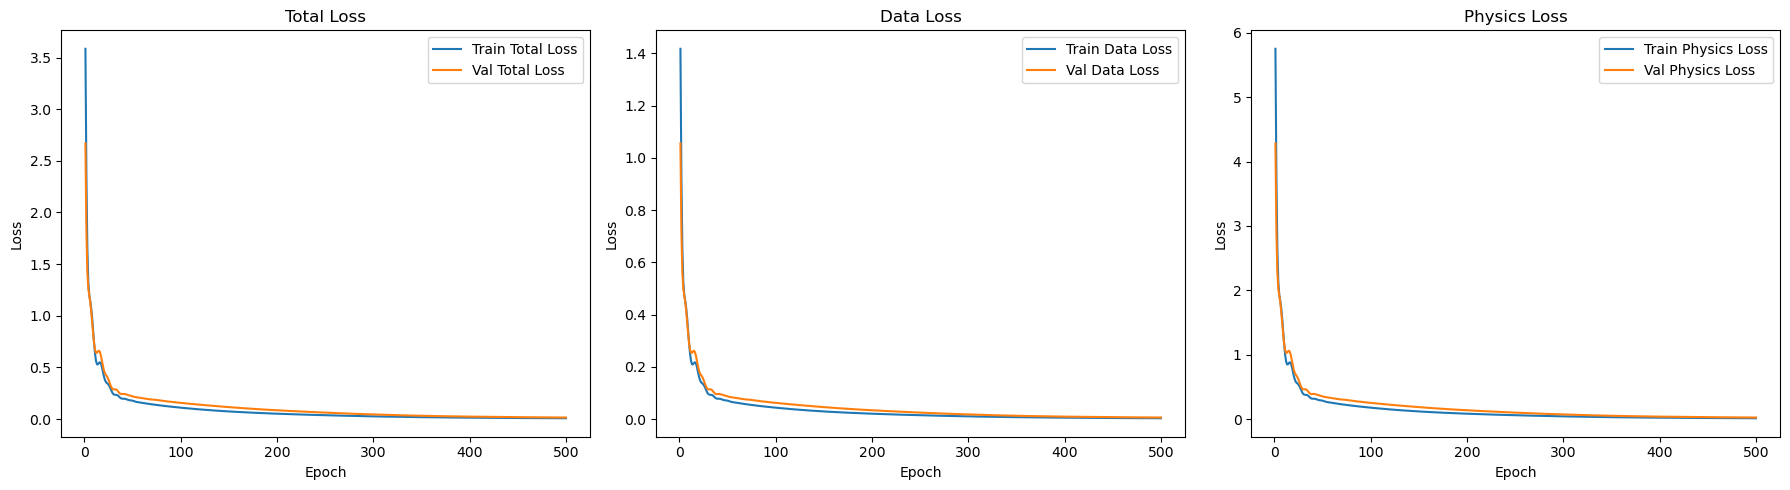

In [ ]:
# Observamos que el modelo tiene un convergencia muy rápida gracias a la función de pérdidad física, y no sufre de overfitting, porque el rendimiento se mantiene constante en los datos de validación
model.plot_history()

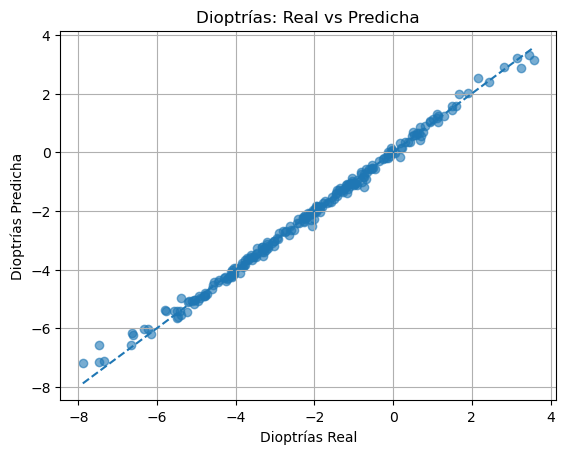

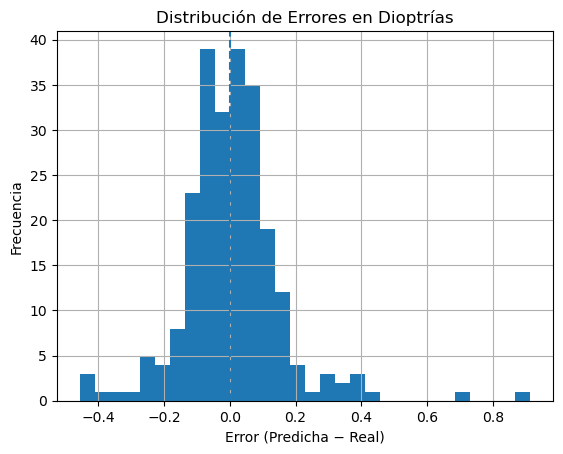

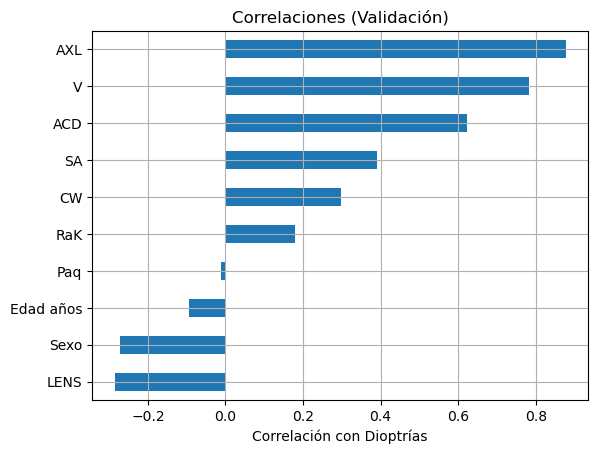

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Datos de validación en TensorFlow
X_test_norm = model.X_test_norm
X_test = model.X_test
y_test = model.y_test

# Obtener predicciones de dioptrías (normalizado → original)
diop_pred_norm = model(X_test_norm, training=False)
diop_pred = (diop_pred_norm * model.y_std + model.y_mean).numpy().flatten()
diop_real = y_test.numpy().flatten()

# Ejemplo 1: Scatter plot simple Real vs Predicho
plt.figure()
plt.scatter(diop_real, diop_pred, alpha=0.6)
min_val, max_val = diop_real.min(), diop_real.max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--')
plt.xlabel('Dioptrías Real')
plt.ylabel('Dioptrías Predicha')
plt.title('Dioptrías: Real vs Predicha')
plt.grid(True)
plt.show()

# Ejemplo 2: Histograma de errores
errors = diop_pred - diop_real
plt.figure()
plt.hist(errors, bins=30)
plt.xlabel('Error (Predicha − Real)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores en Dioptrías')
plt.grid(True)
plt.axvline(0, linestyle='--')
plt.show()

# Ejemplo 3: Correlaciones de features con Dioptrías real
# Creamos DataFrame para facilitar el cálculo de correlaciones
columnas = ['CW','Edad años','Sexo','SA','V','AXL','LENS','Paq','RaK','ACD']
df_val = pd.DataFrame(X_test.numpy(), columns=columnas)
df_val['Dioptrías'] = diop_real

corrs = df_val.corr()['Dioptrías'].drop('Dioptrías')
plt.figure()
corrs.sort_values().plot.barh()
plt.xlabel('Correlación con Dioptrías')
plt.title('Correlaciones (Validación)')
plt.grid(True)
plt.show()


## Optimización de Hiperparametros

In [ ]:
# Búsqueda de hiperparámetros usando Grid Search simple
import itertools
import numpy as np

# Definir rangos para lambda_data y lambda_physics
lambda_data_values = [0.1, 0.5, 1.0]
lambda_physics_values = [0.1, 0.5, 1.0]

# Resultados
results = []

# Combinaciones posibles de hiperparámetros
for ld, lp in itertools.product(lambda_data_values, lambda_physics_values):
    print(f"Entrenando modelo con lambda_data={ld}, lambda_physics={lp}")

    model = PINN_model(
        X_train, X_test,
        y_train, y_test,
        lambda_data=ld,
        lambda_physics=lp
    )

    history = model.fit_PINN(
        num_epochs=500,
        print_every=100,
        save_path=f"best_model_ld{ld}_lp{lp}.weights.h5"
    )

    # Guardar el mejor resultado de validación
    best_val_loss = min(history['val_total'])
    results.append({
        'lambda_data': ld,
        'lambda_physics': lp,
        'best_val_loss': best_val_loss
    })

# Convertir a DataFrame para visualizar
import pandas as pd
results_df = pd.DataFrame(results)



Entrenando modelo con lambda_data=0.1, lambda_physics=0.1
Epoch 100/500 - Train: 0.0242 (Data: 0.0480, Physics: 0.1945) | Val: 0.0373 (Data: 0.0737, Physics: 0.2989)
Epoch 200/500 - Train: 0.0070 (Data: 0.0139, Physics: 0.0566) | Val: 0.0137 (Data: 0.0272, Physics: 0.1101)
Epoch 300/500 - Train: 0.0036 (Data: 0.0071, Physics: 0.0290) | Val: 0.0082 (Data: 0.0162, Physics: 0.0656)
Epoch 400/500 - Train: 0.0021 (Data: 0.0042, Physics: 0.0169) | Val: 0.0055 (Data: 0.0108, Physics: 0.0440)
Epoch 500/500 - Train: 0.0013 (Data: 0.0025, Physics: 0.0102) | Val: 0.0038 (Data: 0.0075, Physics: 0.0305)
Entrenamiento finalizado. Mejor modelo en época 500 con pérdida de validación: 0.0038
Entrenando modelo con lambda_data=0.1, lambda_physics=0.5
Epoch 100/500 - Train: 0.0812 (Data: 0.0382, Physics: 0.1549) | Val: 0.1133 (Data: 0.0532, Physics: 0.2160)
Epoch 200/500 - Train: 0.0299 (Data: 0.0140, Physics: 0.0570) | Val: 0.0542 (Data: 0.0255, Physics: 0.1033)
Epoch 300/500 - Train: 0.0157 (Data: 0.007

In [ ]:
results_df.sort_values('best_val_loss')

,lambda_data,lambda_physics,best_val_loss
0,0.1,0.1,0.003806
4,0.5,0.5,0.007140
6,1.0,0.1,0.008447
3,0.5,0.1,0.009747
7,1.0,0.5,0.011020
1,0.1,0.5,0.014545
5,0.5,1.0,0.019659
2,0.1,1.0,0.020780
8,1.0,1.0,0.020993


In [ ]:
import itertools
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd

# Seleccionar la mejor combinación lambda_data/lambda_physics
top_config = results_df.sort_values('best_val_loss').iloc[0]
best_ld = top_config['lambda_data']
best_lp = top_config['lambda_physics']

# Hiperparámetros a evaluar
tested_learning_rates = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5]
tested_activations = ['tanh', 'relu', 'sigmoid', 'leaky_relu']

extended_results = []

for lr, act in itertools.product(tested_learning_rates, tested_activations):
    print(f"Entrenando con lr={lr}, act={act}")

    # Crear instancia
    model = PINN_model(
        X_train, X_test,
        y_train, y_test,
        lambda_data=best_ld,
        lambda_physics=best_lp
    )

    # Set learning rate y optimizer
    model.learning_rate = lr
    model.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Selección de activación (leaky_relu requiere objeto)
    if act == 'leaky_relu':
        activation_fn = tf.keras.layers.LeakyReLU(alpha=0.01)
    else:
        activation_fn = act

    # Redefinir arquitectura con activación variable y unidades fijas
    model.dense0 = layers.Dense(X_train.shape[1], activation=activation_fn)
    model.dense1 = layers.Dense(64, activation=activation_fn)
    model.dense2 = layers.Dense(128, activation=activation_fn)
    model.dense3 = layers.Dense(64, activation=activation_fn)
    model.dense4 = layers.Dense(32, activation=activation_fn)
    model.output_layer = layers.Dense(y_train.shape[1])

    history = model.fit_PINN(
        num_epochs=500,
        print_every=100,
        save_path=f"best_PINN_lr{lr}_act{act}.weights.h5"
    )

    best_val_loss = min(history['val_total'])
    extended_results.append({
        'learning_rate': lr,
        'activation': act,
        'best_val_loss': best_val_loss
    })

extended_df = pd.DataFrame(extended_results)
print(extended_df.sort_values('best_val_loss'))


Entrenando con lr=0.01, act=tanh


C:\Users\Ruben\anaconda3\Lib\site-packages\keras\src\layers\layer.py:372: UserWarning: `build()` was called on layer 'pinn_model_89', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
extended_df.sort_values('best_val_loss')

# SHAP


### ¿Qué es SHAP?

SHAP (SHapley Additive exPlanations) es una técnica de interpretación basada en valores de Shapley provenientes de la teoría de juegos. Explica cómo contribuye cada característica a las predicciones individuales y globales del modelo.

---

### Aplicación en el modelo PINN

El análisis SHAP realizado sigue estos pasos:

1. **Selección de muestras:**

   * **X\_background:** Muestras base del conjunto de prueba.
   * **X\_to\_explain:** Muestras específicas a explicar.

2. **Nombres de variables:**

   ```python
   feature_names = ['CW','Edad años','Sexo','SA','V','AXL','LENS','Paq','RaK','ACD']
   ```

3. **Creación del explainer:**

   ```python
   explainer = shap.Explainer(model.predict_fn, X_background_df)
   ```

4. **Cálculo de valores SHAP:**

   ```python
   shap_values = explainer(X_to_explain_df)
   ```

---

### Visualizaciones SHAP

#### Gráfico global de importancia:

```python
shap.plots.bar(shap_values, max_display=10)
```

Muestra el impacto promedio de cada característica.

#### Gráfico individual tipo "Waterfall":

```python
shap_single = shap.Explanation(
    values=shap_values[0].values,
    base_values=shap_values[0].base_values,
    data=X_to_explain[0],
    feature_names=fb
* Verifica que los nombres coincidan con las variables del modelo.


In [ ]:
import shap

In [ ]:
# Selecciona muestras de fondo (background) y muestras objetivo
X_background = model.X_test_no_norm.numpy()[:200]      # muestra para calcular valores base
X_to_explain = model.X_test_no_norm.numpy()[201:205]   # pacientes a explicar

# Nombres de variables (deben coincidir con el orden de entrada)
feature_names = ['CW','Edad años','Sexo','SA','V','AXL','LENS','Paq','RaK','ACD']


In [ ]:
# Crear el explainer
explainer = shap.Explainer(model.predict_fn, X_background)

# Calcular valores SHAP para cada paciente a explicar
shap_values = explainer(X_to_explain)


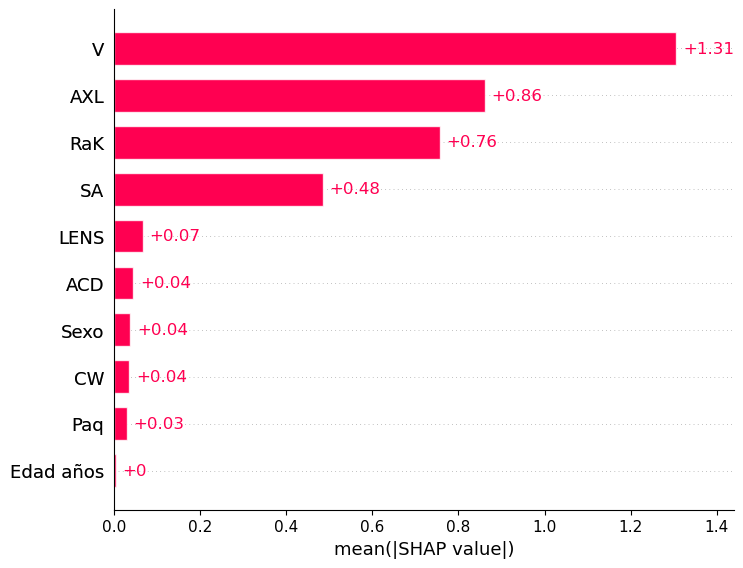

In [ ]:
# Asegúrate de usar DataFrame para que SHAP tenga los nombres
X_background_df = pd.DataFrame(X_background, columns=feature_names)
X_to_explain_df = pd.DataFrame(X_to_explain, columns=feature_names)

# Recalcular explainer
explainer = shap.Explainer(model.predict_fn, X_background_df)

# Obtener valores SHAP con nombres
shap_values = explainer(X_to_explain_df)

# Mostrar gráfico global de importancia
shap.plots.bar(shap_values, max_display=10)

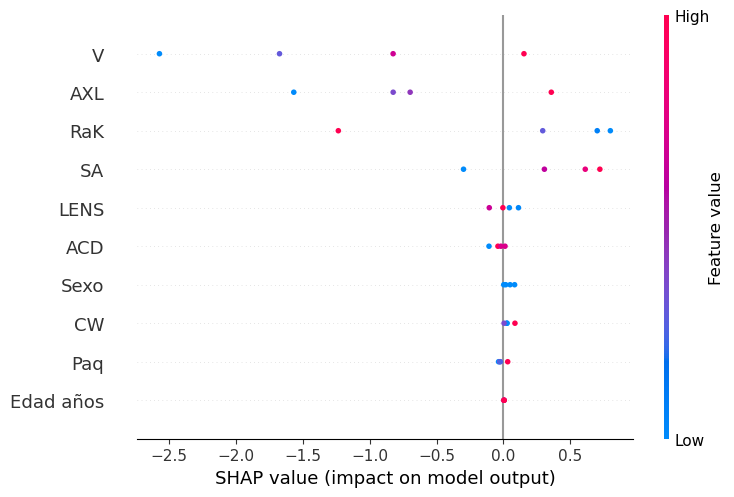

In [ ]:

# 7. Gráfico 3: Beeswarm plot (impacto y dirección del efecto)
shap.plots.beeswarm(shap_values, max_display=10)

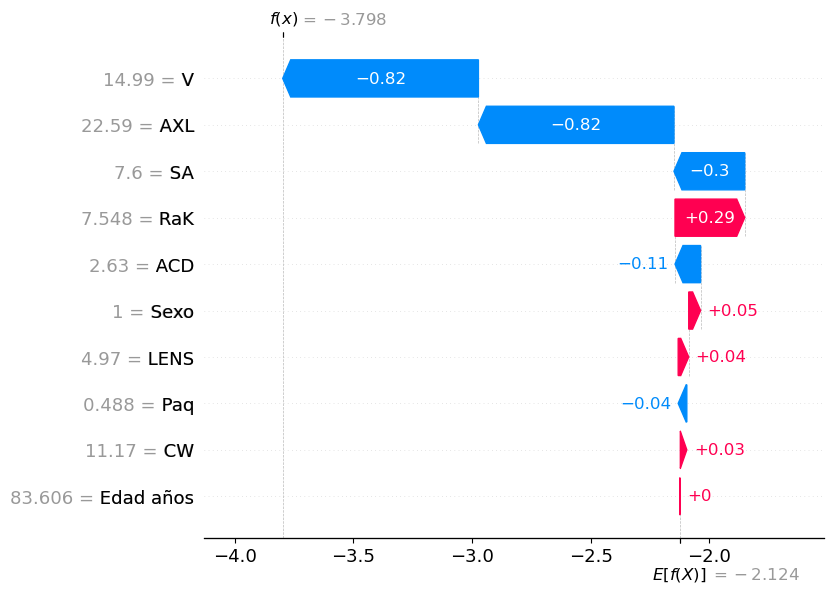

In [ ]:
shap_single = shap.Explanation(
    values=shap_values[0].values,          # valores SHAP individuales
    base_values=shap_values[0].base_values, # valor de referencia del modelo
    data=X_to_explain[0],                  # valores reales del paciente
    feature_names=feature_names            # nombres legibles
)

shap.plots.waterfall(shap_single)         # visualización individual


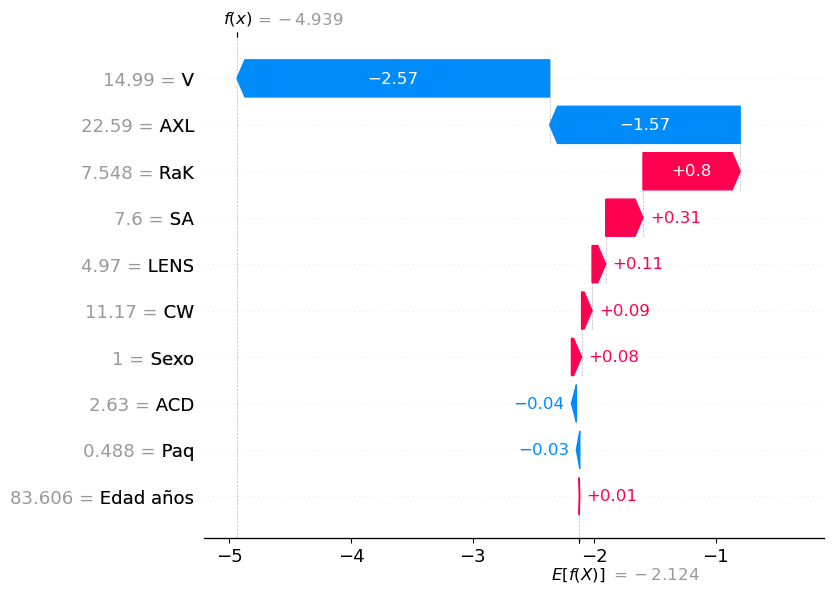

In [ ]:
shap_single = shap.Explanation(
    values=shap_values[1].values,          # valores SHAP individuales
    base_values=shap_values[1].base_values, # valor de referencia del modelo
    data=X_to_explain[0],                  # valores reales del paciente
    feature_names=feature_names            # nombres legibles
)

shap.plots.waterfall(shap_single)         # visualización individual


In [ ]:
data.head()

,Sexo,Edad años,OD/OI,AXL,ACD,LENS,Paq,CW,Eje K1,Eje K2,Cil,RaK,SA,V,Dioptrias
0,0,81.375000,0,23.30,3.34,4.21,0.570,11.01,76,166.0,-0.75,7.590240,7.55,15.75,-1.670990
1,0,81.375000,1,23.09,3.27,4.37,0.573,10.91,86,176.0,-1.40,7.478396,7.64,15.45,-1.717270
2,1,85.305556,0,21.86,2.92,5.21,0.607,11.10,143,53.0,-0.26,7.401316,8.13,13.73,-5.553518
3,1,85.305556,1,21.72,2.85,5.16,0.588,11.17,84,174.0,-0.98,7.322630,8.01,13.71,-5.601718
5,1,69.558333,1,21.53,2.49,5.28,0.564,11.11,170,80.0,-1.26,7.332175,7.77,13.76,-6.389554


## Resultados SHAP (INFORME)

In [ ]:
validacion_informe.head(10)

,Sexo,Edad años,OD/OI,AXL,ACD,LENS,Paq,CW,Eje K1,Eje K2,Cil,RaK,SA,V,Dioptrias,Dioptrias_estimadas
1468,0,79.569444,1,23.87,3.42,4.66,0.531,11.79,78,168.0,-0.88,7.621951,8.08,15.79,-0.134613,-0.140082
1469,1,89.913889,0,22.97,2.86,4.71,0.493,11.56,90,0.0,-0.78,7.767549,7.57,15.40,-3.753990,-3.745269
1470,1,89.913889,1,22.85,2.70,5.03,0.485,11.58,95,5.0,-1.57,7.886435,7.73,15.12,-4.799459,-4.758055
1473,1,44.322222,0,22.72,3.32,4.21,0.552,11.98,12,102.0,-0.96,7.691431,7.53,15.19,-4.124564,-4.163764
1474,1,44.322222,1,23.01,3.22,4.31,0.553,12.03,166,76.0,-0.96,7.712523,7.53,15.48,-3.286319,-3.357743
1475,0,84.088889,0,24.36,3.34,5.23,0.549,11.61,101,11.0,-2.29,7.729303,8.57,15.79,0.675228,0.663778
1476,0,84.088889,1,24.69,3.70,4.84,0.516,11.83,90,0.0,-1.85,7.802566,8.54,16.15,1.232408,1.273079
1477,1,83.075000,0,23.62,3.07,4.58,0.498,11.44,27,117.0,-1.19,8.027114,7.65,15.97,-3.022539,-2.951441
1480,0,84.541667,0,23.57,3.40,4.81,0.476,11.55,136,46.0,-0.64,7.658271,8.21,15.36,-1.267450,-1.285281
1481,0,84.541667,1,23.76,3.95,4.11,0.477,11.77,75,165.0,-1.92,7.526762,8.06,15.70,0.094107,-0.057072


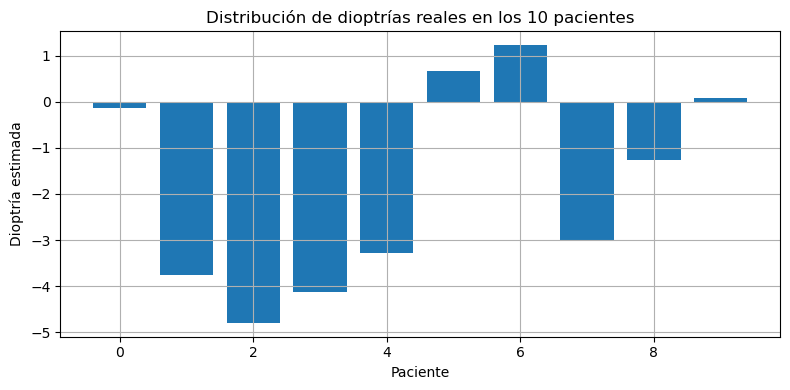

In [ ]:
# 4. Gráfico 1: Distribución de dioptrías reales
plt.figure(figsize=(8, 4))
plt.bar(x=list(range(len(validacion_informe["Dioptrias"]))), height=validacion_informe["Dioptrias"])
plt.xlabel('Paciente')
plt.ylabel('Dioptría estimada')
plt.title('Distribución de dioptrías reales en los 10 pacientes')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
model.X_test_no_norm.shape

TensorShape([238, 10])

In [ ]:
X_to_explain_df.shape

(10, 10)

In [ ]:
# Visualizaciones SHAP para informe con validacion_informe


# 1. Selección de variables usadas por el modelo
variables_usadas = ['CW', 'Edad años', 'Sexo', 'SA', 'V', 'AXL', 'LENS', 'Paq', 'RaK', 'ACD']
X_to_explain_df = validacion_informe[variables_usadas].copy()

# 2. Conjunto de referencia (background) para SHAP: primeras 200 muestras del set de test
X_background = model.X_test.numpy()[:200]  # array shape (200, 10)

# 3. Predicciones reales de dioptrías
# predict_fn retorna array de forma (n_samples, 1) o (n_samples,)
dioptrias_estimadas = model.predict_fn(X_to_explain_df.values).ravel()

X_to_explain_df.head(10)

,CW,Edad años,Sexo,SA,V,AXL,LENS,Paq,RaK,ACD
1468,11.79,79.569444,0,8.08,15.79,23.87,4.66,0.531,7.621951,3.42
1469,11.56,89.913889,1,7.57,15.40,22.97,4.71,0.493,7.767549,2.86
1470,11.58,89.913889,1,7.73,15.12,22.85,5.03,0.485,7.886435,2.70
1473,11.98,44.322222,1,7.53,15.19,22.72,4.21,0.552,7.691431,3.32
1474,12.03,44.322222,1,7.53,15.48,23.01,4.31,0.553,7.712523,3.22
1475,11.61,84.088889,0,8.57,15.79,24.36,5.23,0.549,7.729303,3.34
1476,11.83,84.088889,0,8.54,16.15,24.69,4.84,0.516,7.802566,3.70
1477,11.44,83.075000,1,7.65,15.97,23.62,4.58,0.498,8.027114,3.07
1480,11.55,84.541667,0,8.21,15.36,23.57,4.81,0.476,7.658271,3.40
1481,11.77,84.541667,0,8.06,15.70,23.76,4.11,0.477,7.526762,3.95


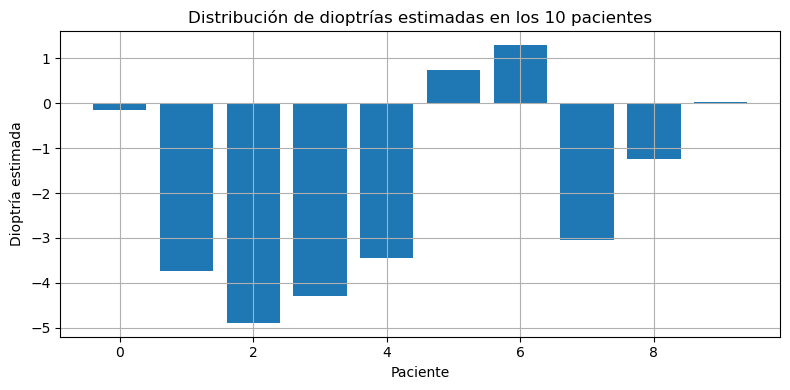

In [ ]:
# 4. Gráfico 1: Distribución de dioptrías estimadas
plt.figure(figsize=(8, 4))
plt.bar(x=list(range(len(dioptrias_estimadas))), height=dioptrias_estimadas)
plt.xlabel('Paciente')
plt.ylabel('Dioptría estimada')
plt.title('Distribución de dioptrías estimadas en los 10 pacientes')
plt.grid(True)
plt.tight_layout()
plt.show()

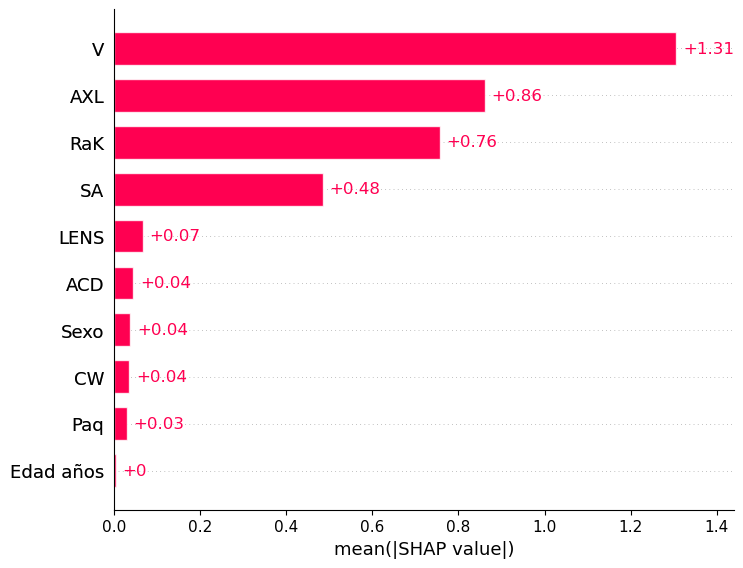

In [ ]:
# 5. Corregir nombres manualmente si SHAP los ha perdido (suele pasar con arrays directos)
shap_values.feature_names = variables_usadas
shap_values.data = X_to_explain_df.values

# 6. Gráfico de barras con nombres correctos
shap.plots.bar(shap_values, max_display=10)

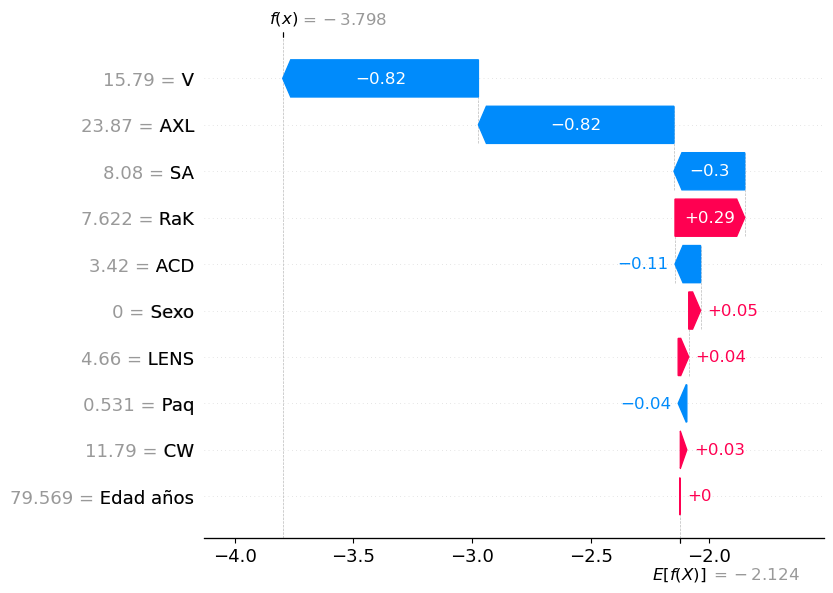

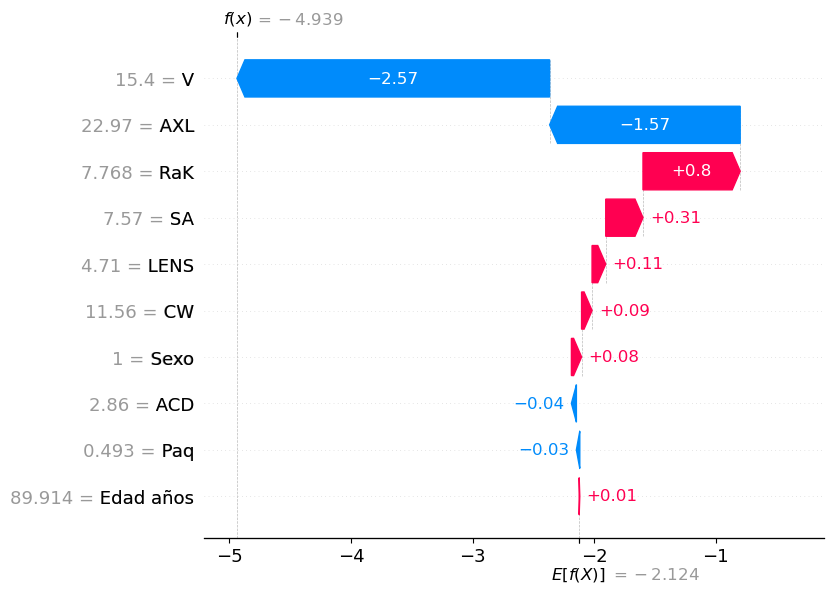

In [ ]:
# 8. Gráficos 4 y 5: Waterfall explicativo para pacientes 1 y 2
for idx in [0, 1]:
    shap_single = shap.Explanation(
        values=shap_values.values[idx],
        base_values=shap_values.base_values[idx],
        data=X_to_explain_df.iloc[idx].values,
        feature_names=variables_usadas
    )
    shap.plots.waterfall(shap_single)

In [ ]:
# 9. Tabla de ranking de importancia media absoluta
ranking_df = pd.DataFrame({
    'Variable': variables_usadas,
    'Impacto medio absoluto': abs(shap_values.values).mean(axis=0)
}).sort_values(by='Impacto medio absoluto', ascending=False)
print(ranking_df)


    Variable  Impacto medio absoluto
6       LENS                1.364518
5        AXL                1.364038
9        ACD                0.864766
4          V                0.745747
8        RaK                0.698121
3         SA                0.534806
2       Sexo                0.029022
0         CW                0.015773
1  Edad años                0.014278
7        Paq                0.011241
